# Lending Club Data - Driverless AI Python Tutorial

**Lending Club** publishes loan data periodically for public use. The anonymized data has information on different loans issued, such as loan_id, loan_amount, what loan grade, credit score etc., and also a **loan_status** variable that indicates whether a loan was _Fully Paid_ or _Charged Off_ (written off because of default).

This python notebook tutorial shows:
- How to get the data from Lending Club site
- Drop some Target Leakage Columns
- Create a train and test data set
- Kick off Automatic Feature Engineering/Automatic Machine Learning with Driverless AI
- Download the test predictions

Prerequisites:
- A Driverless AI instance running with IP address, Username and Password. Please make sure you have that ready and substitute it in the code below


In [1]:
# Replace below with settings in your environment before you run the notebook

driverless_ai_ip = "http://<ip address>:12345" 
driverless_ai_username = "<username>"
driverless_ai_password = "<password>"

### Import numpy, pandas, sklearn etc., to do the data munging


In [2]:
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection


### Download 2007-2011 Loan Data from Lending Club Website

The url provided in the wget command is where the 2007-2011 loan data is. You can also get loan data over different periods from https://www.lendingclub.com/info/download-data.action 

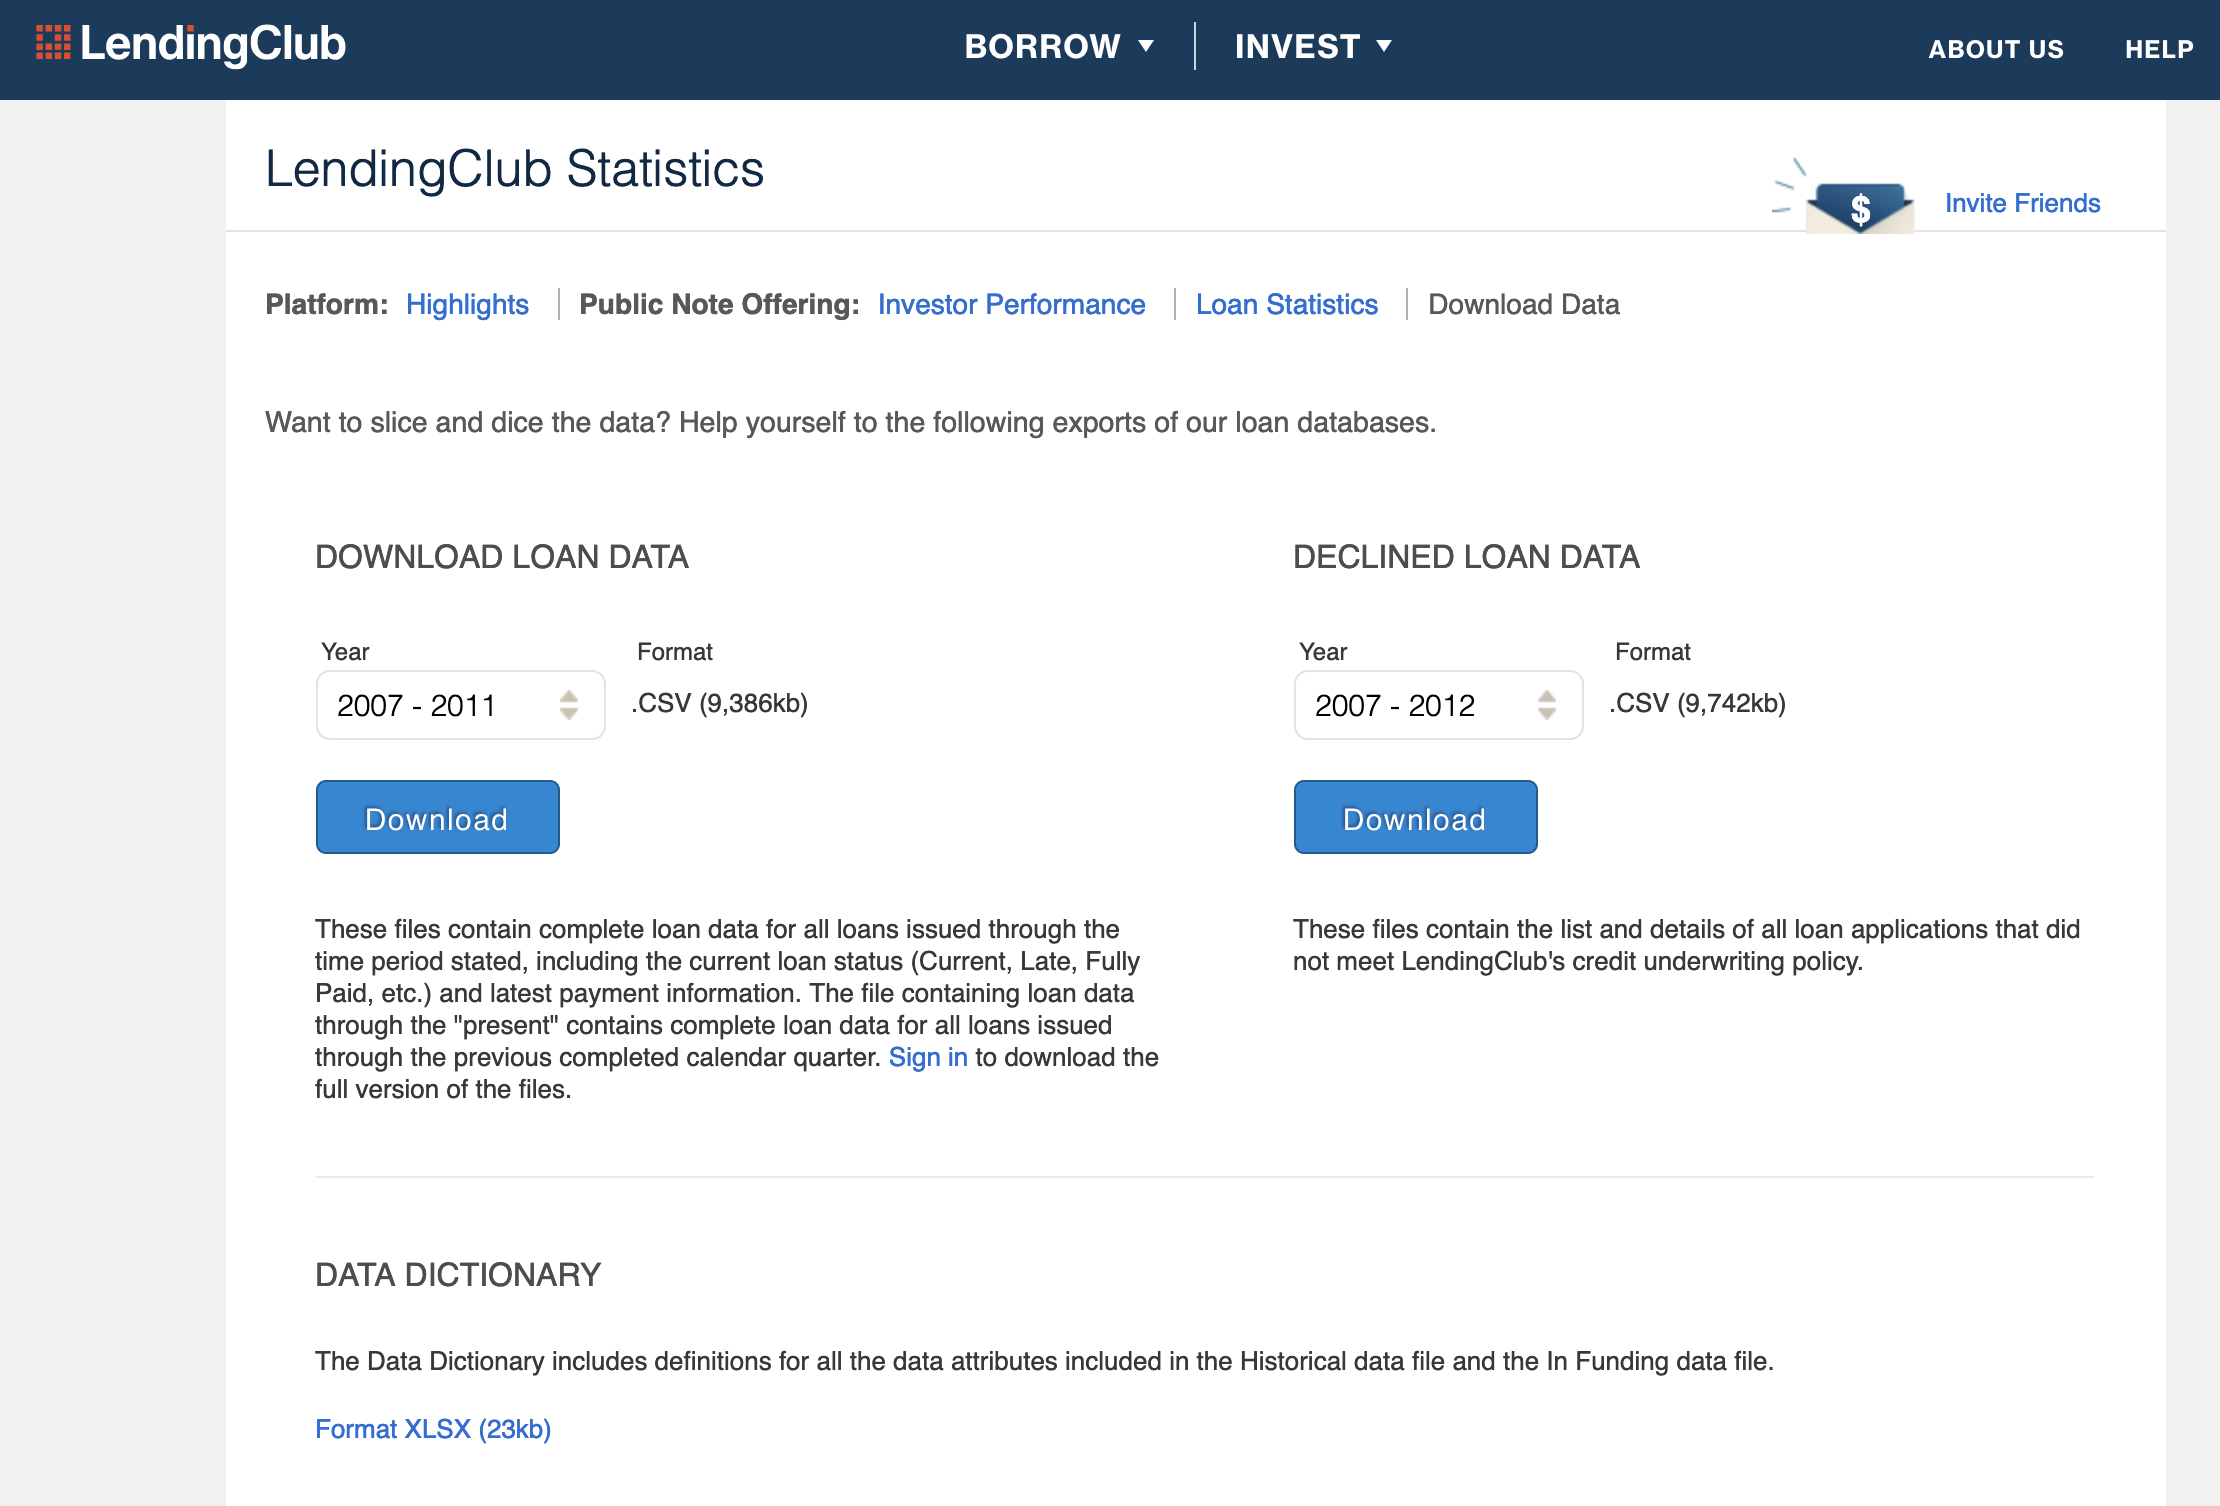

In [3]:
!rm LoanStats3a.csv.zip
!wget --no-check-certificate "https://resources.lendingclub.com/LoanStats3a.csv.zip"

rm: LoanStats3a.csv.zip: No such file or directory
--2019-03-18 19:05:18--  https://resources.lendingclub.com/LoanStats3a.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats3a.csv.zip’

LoanStats3a.csv.zip     [      <=>           ]   9.17M  1.54MB/s    in 5.8s    

2019-03-18 19:05:24 (1.59 MB/s) - ‘LoanStats3a.csv.zip’ saved [9610863]



### Data Dictionary - for Lending Club Data
We next display the data dictionary of the Lending Club Data. 

Note: Though there are 153 columns in the data dictionary, the actual data (in the next section) has only 145 columns

In [4]:
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth',9999)
pd.set_option('display.max_columns',9999)
pd.set_option('display.max_rows',9999)
data_dictionary = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

data_dictionary

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


### Munging the data in Pandas

We first read the data into a Pandas data frame. We skip reading the very first row as it has some non-header information. The target column **loan_status** has really 4 unique values, but as you can see below, it makes sense to fold them to 2 unique possibilities, **Fully Paid** and **Charged Off**, that makes it into a binary classification problem.

In [5]:
# Very first row has non-header data and hence skipping it. Read to a data frame

lc = pd.read_csv("LoanStats3a.csv.zip", skiprows=1,verbose=False, low_memory=False) 
lc.shape

(42538, 145)

In [6]:
# Normalize target column values for a simple binary classification problem

lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', lc['loan_status'])
lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', lc['loan_status'])

# Let's look at the unique values for the target col. Yes - it's a binary classification problem
lc.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan], dtype=object)

In [7]:
# Drop the columns from the data frame that are target leakage ones

ignored_cols = ['inq_last_6mths', 
                'out_prncp', 
                'out_prncp_inv', 
                'total_pymnt', 
                'total_pymnt_inv', 
                'total_rec_prncp', 
                'total_rec_int', 
                'total_rec_late_fee', 
                'recoveries', 
                'collection_recovery_fee', 
                'last_pymnt_d', 
                'last_pymnt_amnt', 
                'next_pymnt_d', 
                'last_credit_pull_d',
                ]

lc = lc.drop(columns=ignored_cols, axis = 1)

In [8]:
# After dropping Target Leakage columns, we have 42,538 rows and 131 columns
lc.shape

(42538, 131)

### Split to Train and Test - 80%/20%  and write it to two CSV files

In [10]:
import csv
import os 

train_path = os.getcwd() + "/train_lc.csv"
test_path = os.getcwd() + "/test_lc.csv"

train_lc, test_lc = model_selection.train_test_split(lc, test_size=0.2)
train_lc.to_csv(train_path, index=False)
test_lc.to_csv(test_path, index=False)


In [11]:
# Let's look at the shape of training data
train_lc.shape

(34030, 131)

In [12]:
# Let's look at the shape of test data

In [13]:
test_lc.shape

(8508, 131)

## Connect to Driverless AI instance 


In [14]:
# If you don't have h2oai_client library, read this doc on how to download it:
# http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python_install_client.html

import h2oai_client
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection
from h2oai_client import Client, ModelParameters, InterpretParameters


h2oai = Client(address = driverless_ai_ip, 
               username = driverless_ai_username,
               password = driverless_ai_password)

### Upload the Train and Test data to Driverless AI

In [15]:
import os

# These two CSV files were created in the previous section

train_path = os.getcwd()+"/train_lc.csv"
test_path = os.getcwd()+ "/test_lc.csv"

train_key = h2oai.upload_dataset_sync(train_path)
test_key = h2oai.upload_dataset_sync(test_path)


### Run an Experiment Preview in Driverless AI
Set the target col to **loan_status**, Accuracy, Time and Interpretability settings of 1,1 and 8. Let's set the _scorer_ to AUC etc., The resulting output will be the execution plan for the experiment, including algorithm selections, cross validation strategy, feature transformations that will be used as decided by the recipe.

In [21]:
target='loan_status'
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train_key.key, 
                                                validset_key='', 
                                                classification=True, 
                                                target_col=target,
                                                dropped_cols=[],
                                                is_time_series = False, 
                                                enable_gpus = True, 
                                                accuracy = 1, time = 1, interpretability = 8, 
                                                config_overrides="""
                                                   enable_tensorflow="On"
                                                   enable_tensorflow_textcnn="On"
                                                   enable_tensorflow_textbigru="On"
                                                   enable_tensorflow_charcnn="On"
                                                """)
exp_preview

['ACCURACY [1/10]:',
 '- Training data size: *34,030 rows, 42 cols*',
 '- Feature evolution: *[LightGBM, XGBoost, GLM]*, *1/3 validation split*',
 '- Final pipeline: *[LightGBM, XGBoost, GLM]*',
 '',
 'TIME [1/10]:',
 '- Feature evolution: *2 individuals*, up to *3 iterations*',
 '- Early stopping: disabled',
 '',
 'INTERPRETABILITY [8/10]:',
 '- Feature pre-pruning strategy: FS',
 '- XGBoost Monotonicity constraints: enabled',
 '- Feature engineering search space (where applicable): [Date, FrequencyEncoding, Identity, Interactions, IsHoliday, NumEncoding, OneHotEncoding, TargetEncoding, Text, WeightOfEvidence]',
 '',
 '[LightGBM, XGBoost, GLM] models to train:',
 '- Model and feature tuning: *2*',
 '- Feature evolution: *3*',
 '- Final pipeline: *1*']

### Run the Experiment 
Let's set the accuracy, time and interpretability settings of 1,1 and 8. Set the _scorer_ to AUC and make it a classification problem by setting *is_classification=True*. We are also passing on the training and test data references to the python API which we uploaded a few steps before. 

Feel free to increase the the settings with higher accuracy and time. Lowering the interpretability will increase feature engineering efforts to get a better model!

In [ ]:
experiment = h2oai.start_experiment_sync(dataset_key=train_key.key,
                                         testset_key = test_key.key,
                                         target_col=target,
                                         dropped_cols=[],
                                         is_classification=True,
                                         accuracy=1,
                                         time=1,
                                         interpretability=8,
                                         scorer="AUC",
                                         enable_gpus=True,
                                         seed=1234,
                                         config_overrides="""
                                             enable_tensorflow='On'
                                             enable_tensorflow_textcnn='On'
                                             enable_tensorflow_textbigru='On'
                                             enable_tensorflow_charcnn='On'
                                         """
                                        )

### Print Training and Test Scores

In [47]:
print("Final Model Score on Training Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Training Data: 0.705
Final Model Score on Test Data: 0.716


### Visualize model score evolving over iterations

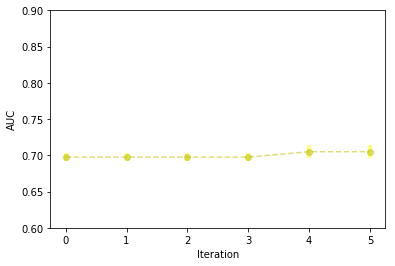

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

# Add scores from experiment iterations
iteration_data = h2oai.list_model_iteration_data(experiment.key, 0, len(experiment.iteration_data))
iterations = list(map(lambda iteration: iteration.iteration, iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, iteration_data))

# Add score from final ensemble
iterations = iterations + [max(iterations) + 1]
scores_mean = scores_mean + [experiment.valid_score]
scores_sd = scores_sd + [experiment.valid_score_sd]

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "y", 
             ecolor='yellow', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.ylim([0.6, .9])
plt.show();

### Download the test predictions ...

In [49]:
h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [50]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,loan_status.Charged Off,loan_status.Fully Paid
0,0.055677,0.944323
1,0.211846,0.788154
2,0.064610,0.935390
3,0.118778,0.881222
4,0.043090,0.956910
